## Hazard assessment for Temperature: Days above threshold and percentiles of extreme temperature

In [2]:
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
from regionmask import mask_geopandas

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import xarray as xr

ERROR 1: PROJ: proj_create_from_database: Open of /work/cmcc/dg07124/miniconda3/envs/climax/share/proj failed


This notebook processes NetCDF files containing data about the number of days where maximum temperature exceeds specific thresholds (e.g., 35°C, 40°C, 45°C) that was calculates previously in the notebook "02_UERRA_indicatorsCalculation.ipynb" and generates maps visualizing these exceedances over Italy.

- We load a shapefile of Europe, then we isolate the portion of the shapefile that corresponds to Italy.
- We search for the *indicators_path* for all NetCDF files that start with 'NumbDays', which contain the number of days with temperatures exceeding the thresholds.
These files are sorted for further processing.

In [3]:
# Path to the folder containing the NetCDF files
indicators_path = '/work/cmcc/dg07124/climax/indicators/uerra'
# Path to save the maps
output_maps = r'/work/cmcc/dg07124/climax/indicators/uerra/maps'

# Read the shapefile for Italy
gdf = gpd.read_file('/work/cmcc/dg07124/climax/data/shp/EU/CNTR_RG_01M_2020_4326.shp')
italy = gdf[gdf.NAME_ENGL == 'Italy']

# Find all files in the directory that start with 'NumbDays'
file_pattern = os.path.join(indicators_path, 'NumbDays*.nc')
indicators_files_NumbDays = sorted(glob.glob(file_pattern))

## Maps of the number of days of above 35, 40 and 45°C 

For each NetCDF file, we extract the variabble *tx_days_above*, which represents the number of days exceeding the temperature thresholds.
We create a mask using the Italy shapefile to limit the data to within Italy’s borders, and the masked data are stored for later use.

In [4]:
# List to store masked data
masked_NumbDays_arrays = []
# Define variable name
variable_name = 'tx_days_above'

# Loop through each NetCDF file, mask the data, and store the results
for file_NumbDays in indicators_files_NumbDays:
    # Open dataset
    ds_NumbDays = xr.open_dataset(file_NumbDays)

    # Extract the variable of interest
    var_NumbDays = ds_NumbDays[variable_name]
    lon = ds_NumbDays['longitude']
    lat = ds_NumbDays['latitude']

    # Create the mask
    mmask = mask_geopandas(italy, lon, lat) * 0 + 1

    # Apply the mask to the dataset
    masked_NumbDays = var_NumbDays * mmask
    masked_NumbDays_arrays.append(masked_NumbDays)

# Find the global min and max values across all masked data arrays for consistent color scaling
global_min_NumbDays = np.nanmin([np.nanmin(NumbDays.values) for NumbDays in masked_NumbDays_arrays])
global_max_NumbDays = np.nanmax([np.nanmax(NumbDays.values) for NumbDays in masked_NumbDays_arrays])
print(f"Global min: {global_min_NumbDays}, Global max: {global_max_NumbDays}")

Global min: 0.0, Global max: 107.7


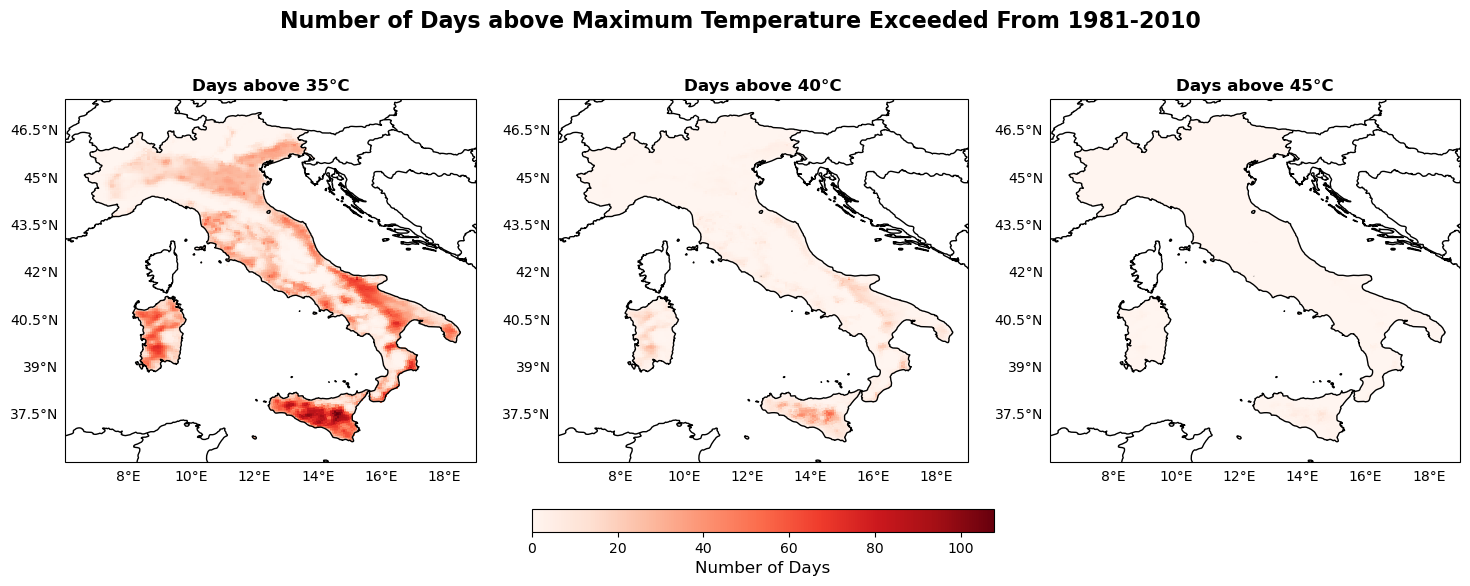

In [5]:
# Titles for the plots
titles_NumbDays = ['Days above 35°C', 'Days above 40°C', 'Days above 45°C']

# Create the figure and axis for plotting (1 row, 3 columns)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Loop through each masked data array and plot
for i, (masked_NumbDays_array, ax, title_NumbDays) in enumerate(zip(masked_NumbDays_arrays, axes, titles_NumbDays)):
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

    # Plot the masked data
    im = ax.pcolormesh(masked_NumbDays_array['longitude'], masked_NumbDays_array['latitude'], masked_NumbDays_array.values, cmap='Reds', vmin=global_min_NumbDays, vmax=global_max_NumbDays, transform=ccrs.PlateCarree())
    ax.set_title(title_NumbDays, fontweight='bold')

    # Set extent to focus on Italy
    ax.set_extent([6.0, 19.0, 36.0, 47.5], crs=ccrs.PlateCarree())

# Add a colorbar for all plots
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label('Number of Days', fontsize=12)
fig.suptitle('Number of Days above Maximum Temperature Exceeded From 1981-2010', fontsize=16, fontweight='bold')
output_fig_path = os.path.join(output_maps, f"UERRA_NumDaysTempExceeded_comparison.png")
plt.savefig(output_fig_path)
plt.show()

## Maps of the percentiles of extreme temperature

In [9]:
# Find all files in the directory that start with 'NumbDays'
file_pattern = os.path.join(indicators_path, 'Temp_P*.nc')
TempPercentile_files = sorted(glob.glob(file_pattern))

# List to store masked data
masked_TempPercentile_arrays = []
# Define variable name
variable_name = 't2m'

# Loop through each NetCDF file, mask the data, and store the results
for TempPercentile_file in TempPercentile_files:
    ds_TempPercentile = xr.open_dataset(TempPercentile_file)

    # Extract the variable of interest
    var = ds_TempPercentile[variable_name]
    lon = ds_TempPercentile['longitude']
    lat = ds_TempPercentile['latitude']

    # Create the mask
    mmask = mask_geopandas(italy, lon, lat) * 0 + 1

    # Apply the mask to the dataset
    masked_TempPercentile = var * mmask
    masked_TempPercentile_arrays.append(masked_TempPercentile)

# Find the global min and max values across all masked data arrays for consistent color scaling
global_min_TempPercentile = np.nanmin([np.nanmin(TempPercentile.values) for TempPercentile in masked_TempPercentile_arrays])
global_max_TempPercentile = np.nanmax([np.nanmax(TempPercentile.values) for TempPercentile in masked_TempPercentile_arrays])
print(f"Global min: {global_min_TempPercentile}, Global max: {global_max_TempPercentile}")

Global min: 10.91801757812501, Global max: 47.45762133789064


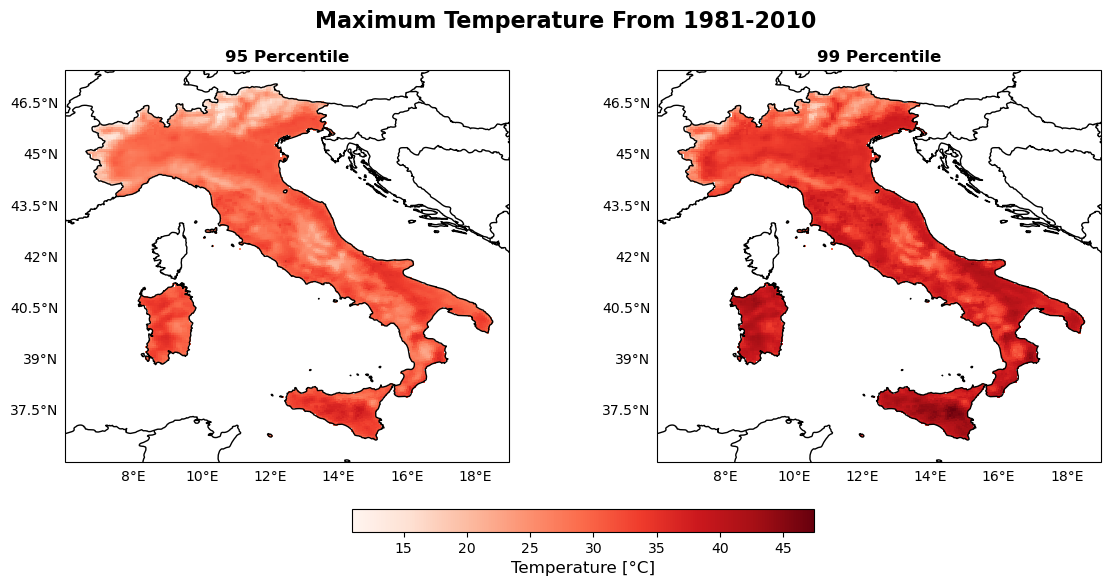

In [10]:
# Titles for the plots
titles_TempPercentile = ['95 Percentile', '99 Percentile']

# Create the figure and axis for plotting (1 row, 3 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Loop through each masked data array and plot
for i, (masked_TempPercentile_array, ax, title_TempPercentile) in enumerate(zip(masked_TempPercentile_arrays, axes, titles_TempPercentile)):
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
    # Add gridlines and format
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

    # Plot the masked data
    im = ax.pcolormesh(masked_TempPercentile_array['longitude'], masked_TempPercentile_array['latitude'], masked_TempPercentile_array.values, cmap='Reds', vmin=global_min_TempPercentile, vmax=global_max_TempPercentile, transform=ccrs.PlateCarree())
    ax.set_title(title_TempPercentile, fontweight='bold')

    # Set extent to focus on Italy
    ax.set_extent([6.0, 19.0, 36.0, 47.5], crs=ccrs.PlateCarree())

# Add a colorbar for all plots
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label('Temperature [°C]', fontsize=12)
fig.suptitle('Maximum Temperature From 1981-2010', fontsize=16, fontweight='bold')
output_fig_path = os.path.join(output_maps, f"UERRA_percentiles_comparison.png")
plt.savefig(output_fig_path)
plt.show()